In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B. 

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [1]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [2]:
using_colab = False

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [5]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [6]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "../models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [19]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [20]:
print(len(masks))
print(masks[0].keys())

66
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


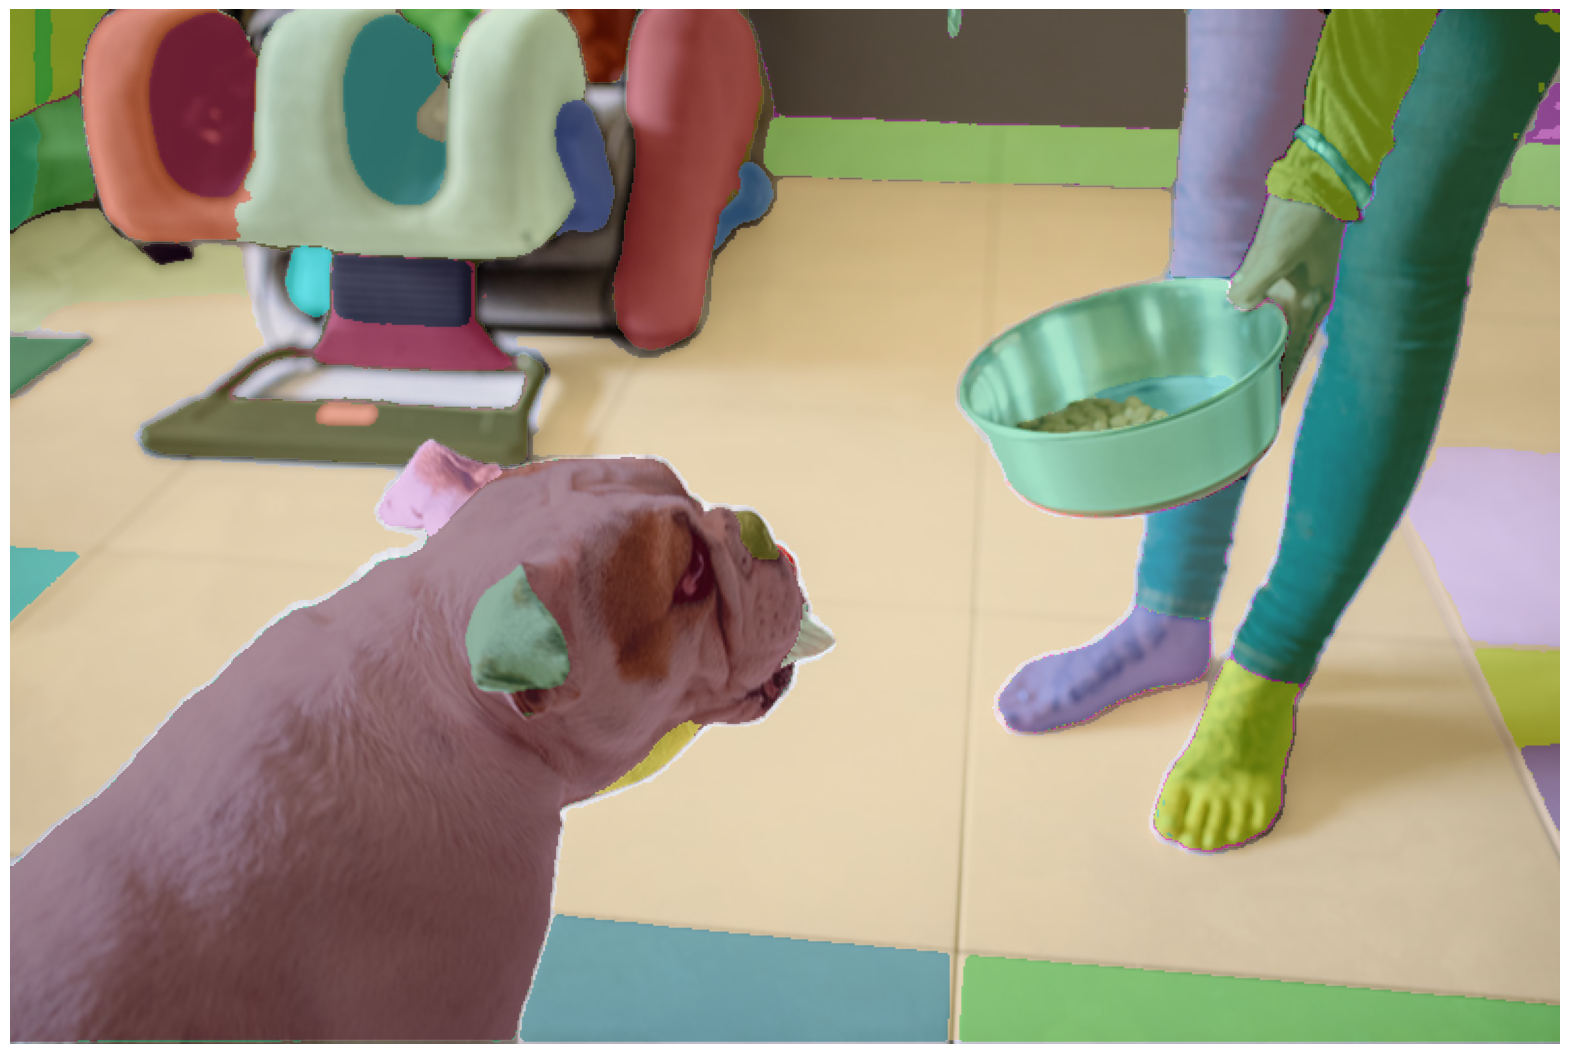

In [22]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
# plt.savefig("/home/wlli/Pictures/auto.png")
plt.show() 

Show all the masks overlayed on the image.

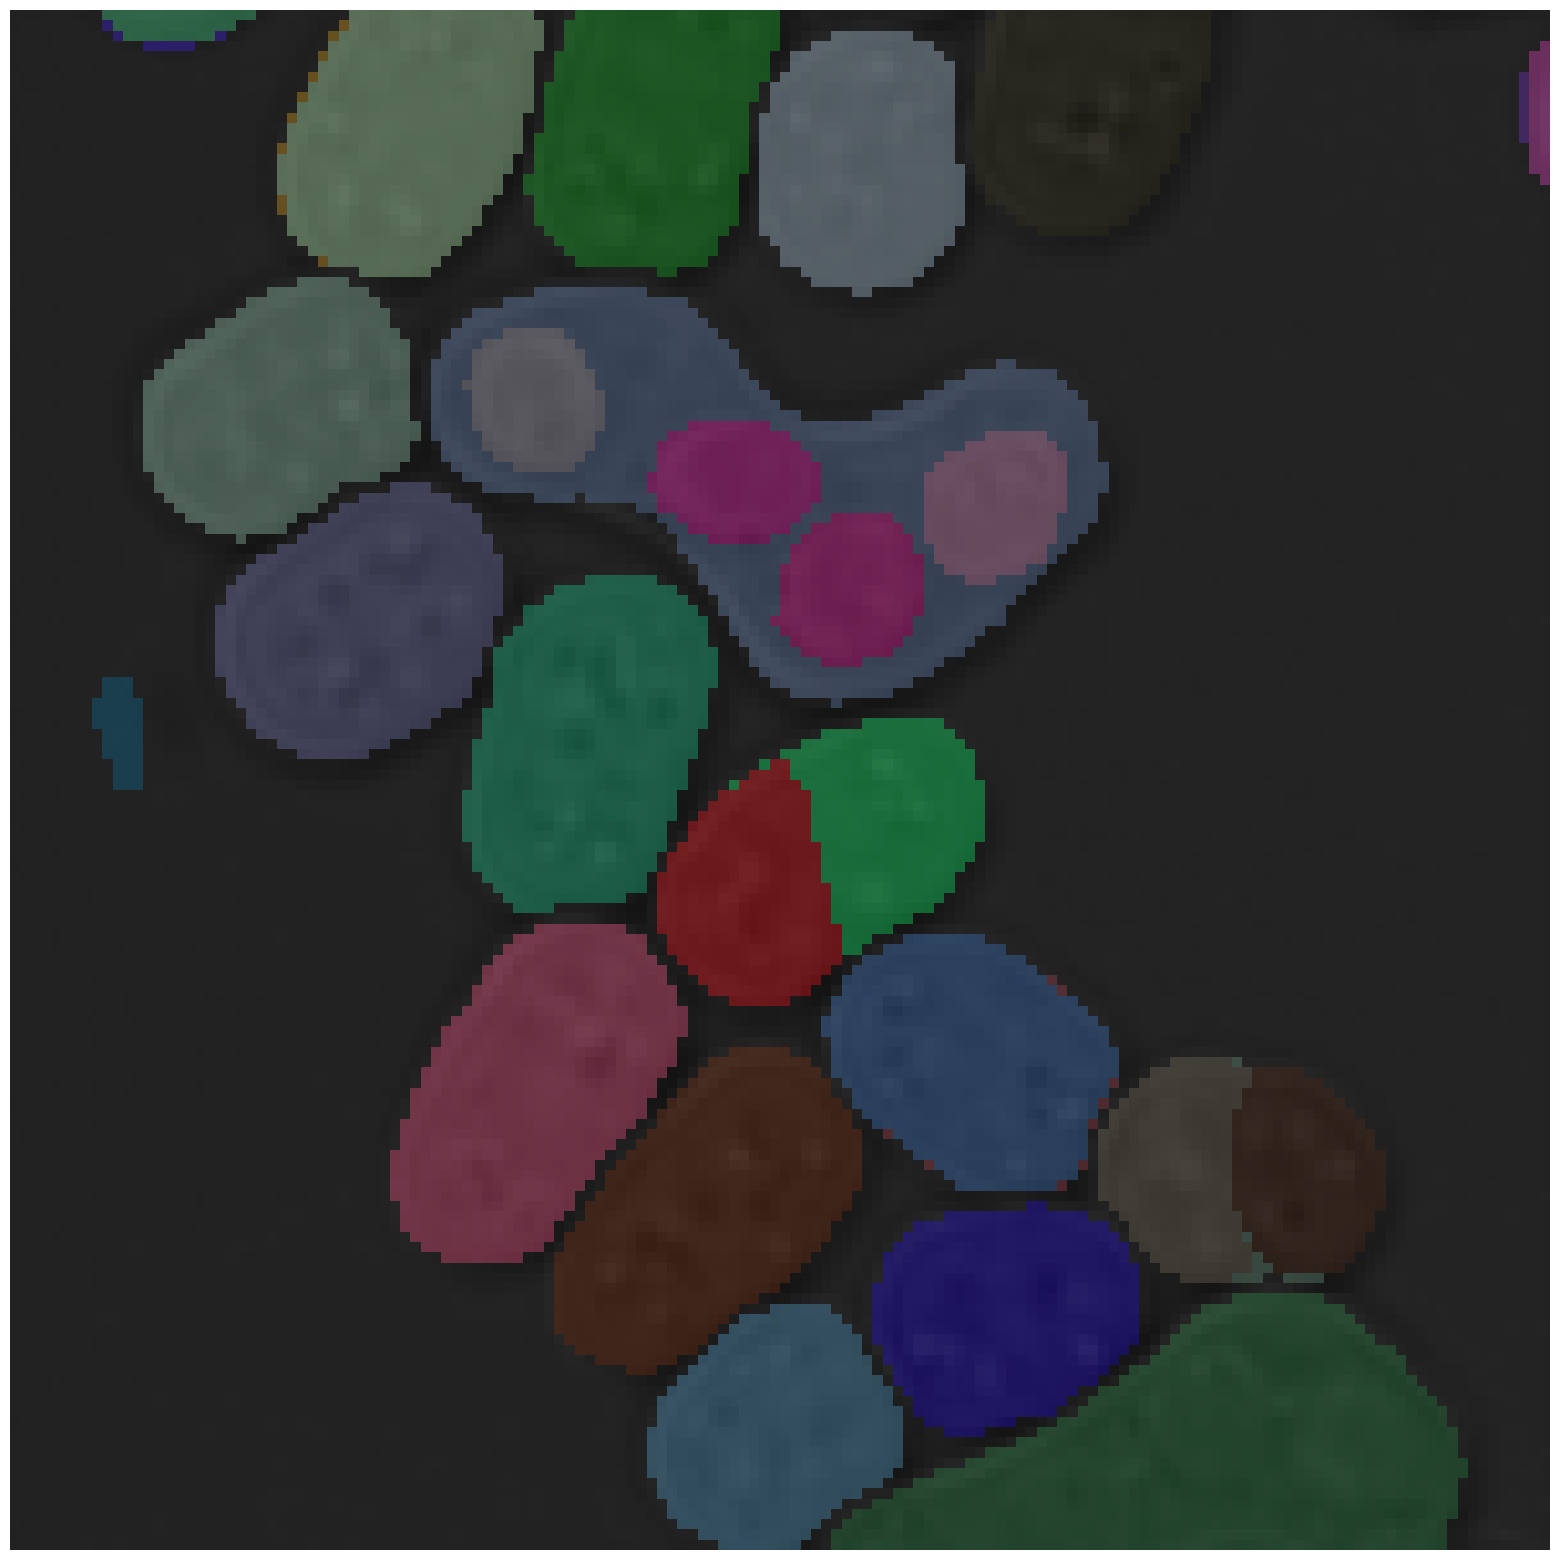

In [31]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [269]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=16,
    points_per_batch=64,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.95,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=10,  # Requires open-cv to run post-processing
)

In [270]:
masks2 = mask_generator_2.generate(image)

In [271]:
masks2

[{'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 4632,
  'bbox': [233, 184, 69, 80],
  'predicted_iou': 0.9875544905662537,
  'point_coords': [[243.375, 243.375]],
  'stability_score': 0.9727078676223755,
  'crop_box': [0, 0, 354, 354]},
 {'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 4410,
  'bbox': [210, 49, 78, 7

In [272]:
len(masks2)

35

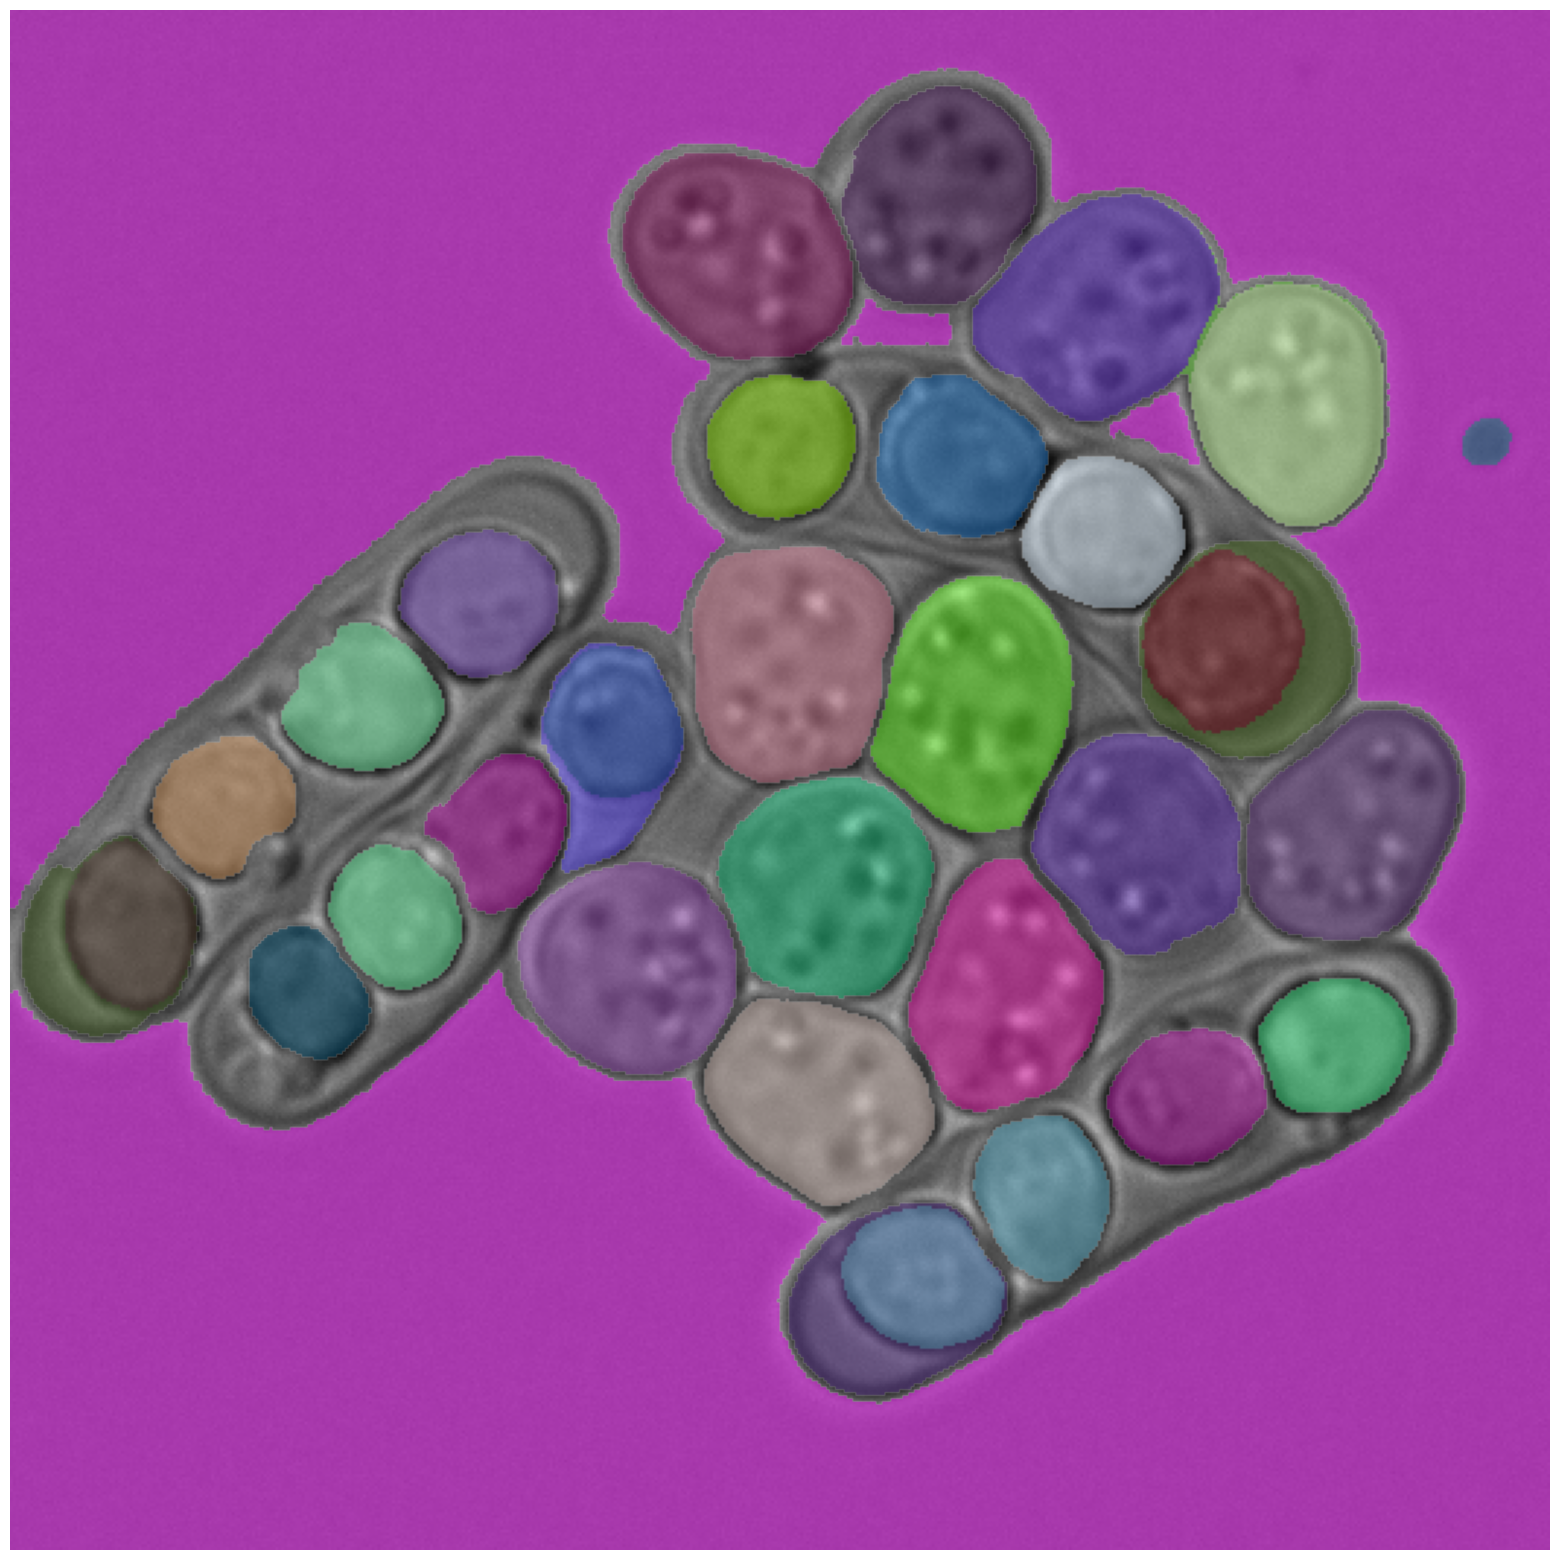

In [273]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 

In [251]:
    def generate(self, image: np.ndarray) -> List[Dict[str, Any]]:
        """
        Generates masks for the given image.

        Arguments:
          image (np.ndarray): The image to generate masks for, in HWC uint8 format.

        Returns:
           list(dict(str, any)): A list over records for masks. Each record is
             a dict containing the following keys:
               segmentation (dict(str, any) or np.ndarray): The mask. If
                 output_mode='binary_mask', is an array of shape HW. Otherwise,
                 is a dictionary containing the RLE.
               bbox (list(float)): The box around the mask, in XYWH format.
               area (int): The area in pixels of the mask.
               predicted_iou (float): The model's own prediction of the mask's
                 quality. This is filtered by the pred_iou_thresh parameter.
               point_coords (list(list(float))): The point coordinates input
                 to the model to generate this mask.
               stability_score (float): A measure of the mask's quality. This
                 is filtered on using the stability_score_thresh parameter.
               crop_box (list(float)): The crop of the image used to generate
                 the mask, given in XYWH format.
        """

        # Generate masks
        mask_data = self._generate_masks(image)

        # Filter small disconnected regions and holes in masks
        if self.min_mask_region_area > 0:
            mask_data = self.postprocess_small_regions(
                mask_data,
                self.min_mask_region_area,
                max(self.box_nms_thresh, self.crop_nms_thresh),
            )

        # Encode masks
        if self.output_mode == "coco_rle":
            mask_data["segmentations"] = [coco_encode_rle(rle) for rle in mask_data["rles"]]
        elif self.output_mode == "binary_mask":
            mask_data["segmentations"] = [rle_to_mask(rle) for rle in mask_data["rles"]]
        else:
            mask_data["segmentations"] = mask_data["rles"]

        # Write mask records
        curr_anns = []
        for idx in range(len(mask_data["segmentations"])):
            ann = {
                "segmentation": mask_data["segmentations"][idx],
                "area": area_from_rle(mask_data["rles"][idx]),
                "bbox": box_xyxy_to_xywh(mask_data["boxes"][idx]).tolist(),
                "predicted_iou": mask_data["iou_preds"][idx].item(),
                "point_coords": [mask_data["points"][idx].tolist()],
                "stability_score": mask_data["stability_score"][idx].item(),
                "crop_box": box_xyxy_to_xywh(mask_data["crop_boxes"][idx]).tolist(),
            }
            curr_anns.append(ann)

        return curr_anns

NameError: name 'List' is not defined